In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
import pandas_datareader as web
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Importing the data
msci_europe = pd.read_excel('Topic4_data_Zerrouki.xlsx', sheet_name = 'Sheet1', parse_dates = True, index_col=0).dropna(axis = 1) #Let's work with companies that are in the index in the whole period, important to see the periods of financial distress
benchmark = pd.read_excel('Topic4_data_Zerrouki.xlsx', sheet_name = 'Sheet2', parse_dates= True, index_col=0)

In [5]:
#Resampling the data to work with monthly returns
msci_monthly = msci_europe.resample('MS').first()
monthly_benchmarck = benchmark.resample('MS').first()

In [6]:
#Computing the returns
msci_returns = msci_monthly.pct_change().dropna(how = 'all')
benchmark_returns = monthly_benchmarck.pct_change().dropna(how = 'all')

In [7]:
companies = ["NESTLE 'N'" , "ROCHE HOLDINGS 'B'", "LVMH", "ASTRAZENECA", "NOVO NORDISK 'B'", "NOVARTIS 'R'", "TOTALENERGIES", "UNILEVER (UK)", "HSBC HOLDINGS", "L'OREAL", "ALLIANZ (XET)","BMW (XET)","BNP PARIBAS", "NOKIA", "ZURICH INSURANCE GROUP"]
describe_df = msci_monthly[companies].copy()
df = msci_returns[companies].copy()

In [8]:
describe_df.describe()

,NESTLE 'N',ROCHE HOLDINGS 'B',LVMH,ASTRAZENECA,NOVO NORDISK 'B',NOVARTIS 'R',TOTALENERGIES,UNILEVER (UK),HSBC HOLDINGS,L'OREAL,ALLIANZ (XET),BMW (XET),BNP PARIBAS,NOKIA,ZURICH INSURANCE GROUP
count,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,51.386508,211.998388,127.217895,3463.043077,141.831046,56.574483,38.550135,2083.200031,606.967692,109.633787,155.048825,49.422846,46.053346,11.081113,320.524034
std,26.877347,57.815961,135.981161,1778.001644,152.917054,16.634672,11.248546,1219.906040,156.699836,79.861323,69.526904,25.245139,15.950404,10.895031,149.741800
min,11.030000,109.004000,18.110700,853.490000,4.890000,13.298000,10.847800,638.940000,184.160000,15.092400,42.785000,10.972000,13.106400,1.661900,101.060000
25%,30.900000,164.250000,47.927400,2425.000000,23.850000,47.451000,33.974700,1192.000000,503.500000,61.589400,102.418000,30.980000,37.562300,4.275500,230.400000
50%,46.500000,213.300000,73.495200,2910.500000,61.100000,54.365000,40.000000,1561.000000,637.160000,79.900000,137.350000,40.480000,47.880100,6.610000,277.250000
75%,71.100000,252.000000,143.300000,4338.500000,259.300000,67.272000,46.220000,2784.000000,719.600000,152.750000,195.750000,72.230000,54.890000,14.960000,346.400000
max,120.400000,410.800000,697.500000,9138.000000,712.100000,91.900000,60.350000,5271.000000,909.780000,406.149900,377.314000,115.500000,88.908900,63.050000,869.727000


In [9]:
monthly_benchmarck.describe()

,MSCI EUROPE U$ - PRICE INDEX
count,325.000000
mean,1395.757612
std,359.722313
min,614.649000
25%,1161.662000
50%,1417.472000
75%,1657.307000
max,2196.911000


In [10]:
#Geometric mean 
geometric_mean = ((1+msci_returns).cumprod().iloc[-1]**(1/len(msci_returns))-1)
geometric_mean

ABB LTD N                   0.002911
ACCIONA                     0.008808
ACCOR                       0.002448
ACS ACTIV.CONSTR.Y SERV.    0.009572
ADECCO GROUP                0.002250
                              ...   
WHITBREAD                   0.005459
WOLTERS KLUWER              0.005929
WPP                         0.007068
ZURICH INSURANCE GROUP      0.002162
3I GROUP                    0.005976
Name: 2021-12-01 00:00:00, Length: 223, dtype: float64

In [11]:
def get_covariance_returns(returns):
    cleaned_returns = returns.fillna(0)
    returns_covariance = np.cov(cleaned_returns.T)
    
    return returns_covariance
covariance_returns = get_covariance_returns(msci_returns)
covariance_returns = pd.DataFrame(covariance_returns, msci_returns.columns, msci_returns.columns)

covariance_returns_correlation = np.linalg.inv(np.diag(np.sqrt(np.diag(covariance_returns))))
covariance_returns_correlation = pd.DataFrame(
    covariance_returns_correlation.dot(covariance_returns).dot(covariance_returns_correlation),
    covariance_returns.index,
    covariance_returns.columns)

In [12]:
Sigma = covariance_returns
sigmaVec = np.diag(Sigma)
numberOfAssets = msci_returns.shape[1]
e = np.ones((numberOfAssets, 1))
# set the constraints
Aeq = e.T
beq = 1
eq_constraint = lambda x: np.dot(Aeq, x) - beq
cons = ({'type': 'eq', 'fun': eq_constraint})


lub = (0, 1)
bnds = ((lub, ) * numberOfAssets)

x0 = np.ones((numberOfAssets, 1)) / (numberOfAssets)
funMDP = lambda x: (-1*x.T @ sigmaVec) / ((x.T @ Sigma @ x) ** 0.5)
# run the optimization
resMDP = minimize(funMDP, x0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)
wMDP = resMDP.x.reshape((numberOfAssets, 1))
    
sigmaMDP = (wMDP.T @ Sigma @ wMDP) ** 0.5

divRatioMDP = -1 * resMDP.fun


In [13]:
def ERCfunc(w, Sigma):
    x = 0
    R = np.dot(Sigma, w)
    for i in range(len(w)):
        for j in range(len(w)):
            x = x + (w[i]*R[i] - w[j]*R[j])**2
    return x

In [14]:
funERC = lambda x: ERCfunc(x, Sigma)
# run the optimization
resERC = minimize(funERC, x0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)
wERC = resERC.x.reshape((numberOfAssets, 1))

sigmaERC = (wERC.T @ Sigma @ wERC) ** 0.5

divRatioERC = (wERC.T @ sigmaVec) / (wERC.T @ Sigma @ wERC) ** 0.5


In [15]:

maxERCReturn = np.matmul(msci_returns, wERC)
maxERCIndex = (1+maxERCReturn).cumprod()


In [16]:

maxDivReturn = np.matmul(msci_returns, wMDP)
maxDivIndex = (1+maxDivReturn).cumprod()

In [17]:
dates = pd.date_range(start = '1994-12-01', end = '2021-12-01', freq = 'MS')

In [18]:
index_df = pd.DataFrame(index = dates)
index_df["Max div"] = maxDivIndex
index_df['ERC'] = maxERCIndex



In [19]:
index_df['MSCI Europe'] = (1+benchmark_returns).cumprod()
index_df['Max div'].iloc[0] = 1
index_df['ERC'].iloc[0] = 1

In [20]:
fig_index = go.Figure()
fig_index.add_trace(go.Scatter(x= dates, y=index_df["Max div"], name="Maximum diversification portfolio"))
fig_index.add_trace(go.Scatter(x= dates, y=index_df['MSCI Europe'], name="Benchmark"))
fig_index.add_trace(go.Scatter(x= dates, y=index_df['ERC'], name="ERC"))
fig_index.update_yaxes(type="log")
fig_index.show()

In [21]:
np.count_nonzero(wMDP, axis = 0)

array([129])

In [22]:
np.count_nonzero(wERC, axis = 0)

array([223])

In [23]:
risk_free = web.DataReader('DGS10', 'fred', start='1994-12-01', end='2021-12-01') #Importing 10 year notes bill
risk_free = risk_free.resample('MS').first()/1200
risk_free.columns = ['RF']

In [24]:
index_ret = index_df.pct_change()
rf = risk_free
CAGR = (index_df.iloc[-1]/index_df.iloc[0])**(12/len(index_df))-1
stats = pd.DataFrame(CAGR, columns=["CAGR"]) 
stats["Volatility"] = index_df.pct_change().std()*(12**0.5)
stats["Excess return"] = index_ret.subtract(rf.values, axis=0).mean()*12
stats["Sharpe ratio"] = stats["Excess return"]/stats["Volatility"]
stats["Tracking error"] = index_ret.sub(index_ret["MSCI Europe"], axis=0).std()*(12**0.5)
stats["Information ratio"] = (index_ret.sub(index_ret["MSCI Europe"], axis=0).mean()*12)/stats["Tracking error"]

In [25]:
stats.style.format({
    "CAGR": '{:,.2%}'.format,
    "Volatility": '{:,.2%}'.format,
    "Excess return": '{:,.2%}'.format,
    "Sharpe ratio": '{:,.2f}'.format,
    "Tracking error": '{:,.2%}'.format,
    "Information ratio": '{:,.2f}'.format
})

,CAGR,Volatility,Excess return,Sharpe ratio,Tracking error,Information ratio
Max div,11.85%,19.27%,9.37%,0.49,12.84%,0.55
ERC,11.18%,15.80%,8.19%,0.52,9.09%,0.64
MSCI Europe,nan%,18.43%,2.39%,0.13,0.00%,nan


In [26]:
wMaxDiv = pd.DataFrame(wMDP, index = msci_monthly.columns)
wERC = pd.DataFrame(wERC, index = msci_monthly.columns)

In [27]:
fig_weights = go.Figure()
fig_weights.add_trace(go.Bar(x=wMaxDiv.index, y=wMaxDiv.iloc[:,-1], name="Maximum diversification weights"))
fig_weights.show()


In [28]:
fig_weights.add_trace(go.Bar(x=wMaxDiv.index, y=wERC.iloc[:,-1], name="Equal risk contribution weights"))
fig_weights.show()

In [29]:
wMaxDiv1 = pd.DataFrame(index = df.index, columns = df.columns).fillna(0)
covMatrixWindow = 36
numberOfPeriods = len(df)
numberOfAssets = len(df.columns)

lb = 0.0   # np.inf*-1
ub = 0.3   # np.inf

startTime = time.time()

for row in range(covMatrixWindow+1, numberOfPeriods):
    
    # select window of returns to compute covariance matrix
    ret = df.iloc[row-covMatrixWindow:row,:]

    # identify valid assets, i.e. those that have all returns
    indexNan = ret.notna().all().tolist()

    # remove non valid assets
    ret_noNan = ret.dropna(axis=1)

    # initialize some variables
    wMD = np.zeros(ret.shape[1])

    numberOfAssets = ret_noNan.shape[1]
    sigma = ret_noNan.cov()
    sigmaVec = np.diag(sigma)
    e = np.ones((numberOfAssets, 1))
    x0 = np.ones((numberOfAssets, 1)) / numberOfAssets
    
    funMDP = lambda x: (-1*x.T @ sigmaVec) / ((x.T @ sigma @ x) ** 0.5)

    Aeq = e.T
    beq = 1
    eq_constraint_1 = lambda x: (Aeq @ x) - beq
    cons_1 = ({'type': 'eq', 'fun': eq_constraint_1})

    # compute weights
    result = minimize(funMDP, x0, method='SLSQP', tol=1e-8, bounds=[(lb, ub)]*numberOfAssets, constraints=cons_1)

    # reattribute weights to the right stocks
    wMD[indexNan] = result.x
    wMaxDiv1.iloc[row] = wMD

print(f"Time to execute: {time.time() - startTime:.0f} seconds")     

Time to execute: 9 seconds


In [30]:
fig_weights1 = go.Figure()
fig_weights1.add_trace(go.Bar(x=wMaxDiv1.columns, y=wMaxDiv1.iloc[-1], name="Market Cap weights"))
fig_weights1.layout.yaxis.tickformat = ",.0%"
fig_weights1.update_layout(title="Weights of various portfolios (as of 01.12.2021)")
fig_weights1.show()

In [31]:
index_df1 = pd.DataFrame(index = dates)
maxDivIndexReturn1 = wMaxDiv1.mul(df).sum(axis=1)
maxDivIndex1 = (1+maxDivIndexReturn1).cumprod()

index_df1["Max div"] = maxDivIndex1

In [32]:
fig_index = go.Figure()
fig_index.add_trace(go.Scatter(x=dates, y=index_df['MSCI Europe'], name="Official MSCI Europe"))
fig_index.add_trace(go.Scatter(x=dates, y=index_df1["Max div"], name="Max div portfolio"))
fig_index.update_yaxes(type="log")
fig_index.show()

In [33]:
def ERCfunc(w, sigma):
    x = 0
    R = np.dot(sigma, w)
    for i in range(len(w)):
        for j in range(len(w)):
            x = x + (w[i]*R[i] - w[j]*R[j])**2
    return x

In [34]:
wERC1 = pd.DataFrame(index = df.index, columns = df.columns).fillna(0)
covMatrixWindow = 36

lb = 0.0   # np.inf*-1
ub = 0.3   # np.inf

startTime = time.time()

for row in range(covMatrixWindow+1, numberOfPeriods):
    
    # select window of returns to compute covariance matrix
    ret = df.iloc[row-covMatrixWindow:row,:]

    # identify valid assets, i.e. those that have all returns
    indexNan = ret.notna().all().tolist()

    # remove non valid assets
    ret_noNan = ret.dropna(axis=1)

    # initialize some variables
    wERCnp = np.zeros(ret.shape[1])

    numberOfAssets = ret_noNan.shape[1]
    sigma = ret_noNan.cov() * numberOfAssets
    e = np.ones((numberOfAssets, 1))
    x0 = np.ones((numberOfAssets, 1)) / numberOfAssets
    
    funERC = lambda x: ERCfunc(x, sigma)

    Aeq = e.T
    beq = 1
    eq_constraint_1 = lambda x: (Aeq @ x) - beq
    cons_1 = ({'type': 'eq', 'fun': eq_constraint_1})

    # compute weights
    result = minimize(funERC, x0, method='SLSQP', tol=1e-8, bounds=[(lb, ub)]*numberOfAssets, constraints=cons_1)

    # reattribute weights to the right stocks
    wERCnp[indexNan] = result.x
    wERC1.iloc[row] = wERCnp

print(f"Time to execute: {time.time() - startTime:.0f} seconds")   

Time to execute: 24 seconds


In [35]:
fig_weights1.add_trace(go.Bar(x=wMaxDiv1.columns, y=wERC1.iloc[-1], name="Equal risk contribution weights"))
fig_weights1.show()

In [36]:
ercIndexReturn = wERC1.mul(df).sum(axis=1)
ercIndex = (1+ercIndexReturn).cumprod()

index_df1['MSCI Europe'] = (1+benchmark_returns).cumprod()
index_df1["ERC"] = ercIndex

In [37]:
fig_index.add_trace(go.Scatter(x=dates, y=index_df1["ERC"], name="Equal risk contribution portfolio"))
fig_index.show()

In [62]:
np.count_nonzero(wMaxDiv1, axis = 1).mean()

9.61111111111111

In [63]:
np.count_nonzero(wERC1, axis = 1).mean()

13.287037037037036

In [40]:
index_df1 = index_df1.drop('1994-12-01')
index_ret1 = index_df1.pct_change()
rf = risk_free.iloc[1:,]
CAGR = (index_df1.iloc[-1]/index_df1.iloc[0])**(12/len(index_df1))-1
stats = pd.DataFrame(CAGR, columns=["CAGR"]) 
stats["Volatility"] = index_df1.pct_change().std()*(12**0.5)
stats["Excess return"] = index_ret1.subtract(rf.values, axis=0).mean()*12
stats["Sharpe ratio"] = stats["Excess return"]/stats["Volatility"]
stats["Tracking error"] = index_ret1.sub(index_ret1['MSCI Europe'], axis=0).std()*(12**0.5)
stats["Information ratio"] = (index_ret1.sub(index_ret1['MSCI Europe'], axis=0).mean()*12)/stats["Tracking error"]


In [41]:
stats.style.format({
    "CAGR": '{:,.2%}'.format,
    "Volatility": '{:,.2%}'.format,
    "Excess return": '{:,.2%}'.format,
    "Sharpe ratio": '{:,.2f}'.format,
    "Tracking error": '{:,.2%}'.format,
    "Information ratio": '{:,.2f}'.format
})

,CAGR,Volatility,Excess return,Sharpe ratio,Tracking error,Information ratio
Max div,11.28%,18.49%,8.72%,0.47,14.73%,0.43
MSCI Europe,4.48%,18.43%,2.39%,0.13,0.00%,nan
ERC,6.47%,13.73%,3.51%,0.26,12.21%,0.09


In [74]:
ff_df = web.DataReader('Europe_3_Factors', 'famafrench', start='1995-1-1', end='2021-12-1')[0]
ff_df = ff_df[['Mkt-RF', 'SMB', 'HML']]
ff_df.index = index_df1.index
ff_df

x = ff_df/100
y = maxDivReturn
y.index= index_df1.index

model = sm.OLS(y, x, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.122
Model:                            OLS   Adj. R-squared (uncentered):              0.114
Method:                 Least Squares   F-statistic:                              14.92
Date:                Sat, 31 Dec 2022   Prob (F-statistic):                    4.06e-09
Time:                        11:43:19   Log-Likelihood:                          491.84
No. Observations:                 324   AIC:                                     -977.7
Df Residuals:                     321   BIC:                                     -966.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [75]:
y = maxERCReturn
y.index= index_df1.index

model = sm.OLS(y, x, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.115
Model:                            OLS   Adj. R-squared (uncentered):              0.107
Method:                 Least Squares   F-statistic:                              13.97
Date:                Sat, 31 Dec 2022   Prob (F-statistic):                    1.40e-08
Time:                        11:43:24   Log-Likelihood:                          553.38
No. Observations:                 324   AIC:                                     -1101.
Df Residuals:                     321   BIC:                                     -1089.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [76]:
ff_df = web.DataReader('Europe_3_Factors', 'famafrench', start='1995-1-1', end='2021-12-1')[0]
ff_df = ff_df[['Mkt-RF', 'SMB', 'HML']]
ff_df.index = index_df1.index
ff_df

x = ff_df/100
y = maxDivIndexReturn1
y.index= index_df1.index

model = sm.OLS(y, x, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.059
Model:                            OLS   Adj. R-squared (uncentered):              0.050
Method:                 Least Squares   F-statistic:                              6.726
Date:                Sat, 31 Dec 2022   Prob (F-statistic):                    0.000205
Time:                        11:43:31   Log-Likelihood:                          494.56
No. Observations:                 324   AIC:                                     -983.1
Df Residuals:                     321   BIC:                                     -971.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [77]:
y = ercIndexReturn
y.index= index_df1.index

model = sm.OLS(y, x, missing='drop')
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.056
Model:                            OLS   Adj. R-squared (uncentered):              0.047
Method:                 Least Squares   F-statistic:                              6.383
Date:                Sat, 31 Dec 2022   Prob (F-statistic):                    0.000326
Time:                        11:43:35   Log-Likelihood:                          592.80
No. Observations:                 324   AIC:                                     -1180.
Df Residuals:                     321   BIC:                                     -1168.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [46]:
log_ret = df

In [47]:
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(15))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum((log_ret.mean(axis = 0) * weights * 12))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [48]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

[Text(0.5, 0, "NESTLE 'N'"),
 Text(1.5, 0, "ROCHE HOLDINGS 'B'"),
 Text(2.5, 0, 'LVMH'),
 Text(3.5, 0, 'ASTRAZENECA'),
 Text(4.5, 0, "NOVO NORDISK 'B'"),
 Text(5.5, 0, "NOVARTIS 'R'"),
 Text(6.5, 0, 'TOTALENERGIES'),
 Text(7.5, 0, 'UNILEVER (UK)'),
 Text(8.5, 0, 'HSBC HOLDINGS'),
 Text(9.5, 0, "L'OREAL"),
 Text(10.5, 0, 'ALLIANZ (XET)'),
 Text(11.5, 0, 'BMW (XET)'),
 Text(12.5, 0, 'BNP PARIBAS'),
 Text(13.5, 0, 'NOKIA'),
 Text(14.5, 0, 'ZURICH INSURANCE GROUP')]

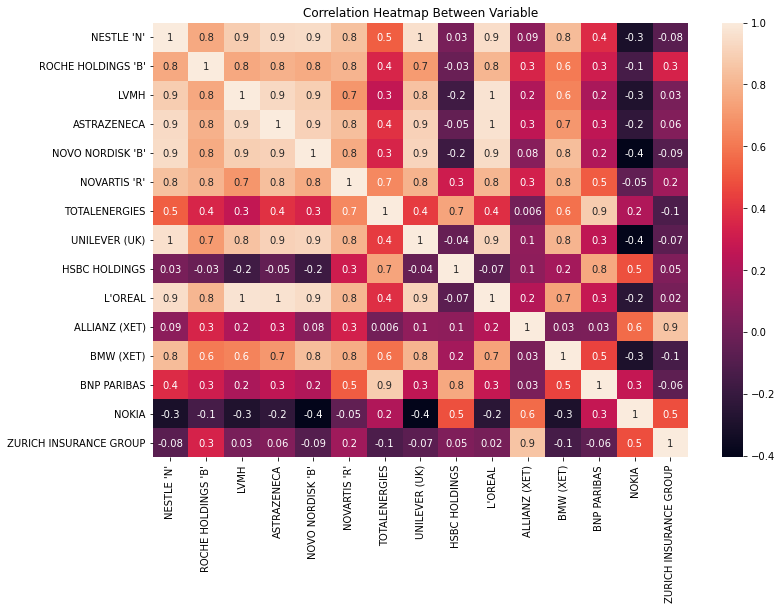

In [49]:
correlation = describe_df.corr(method = 'pearson')
plt.figure(figsize=(12,8))
heatmap=sns.heatmap(correlation, annot=True, fmt='.1g')
heatmap.set_title('Correlation Heatmap Between Variable')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

[Text(0.5, 0, "NESTLE 'N'"),
 Text(1.5, 0, "ROCHE HOLDINGS 'B'"),
 Text(2.5, 0, 'LVMH'),
 Text(3.5, 0, 'ASTRAZENECA'),
 Text(4.5, 0, "NOVO NORDISK 'B'"),
 Text(5.5, 0, "NOVARTIS 'R'"),
 Text(6.5, 0, 'TOTALENERGIES'),
 Text(7.5, 0, 'UNILEVER (UK)'),
 Text(8.5, 0, 'HSBC HOLDINGS'),
 Text(9.5, 0, "L'OREAL"),
 Text(10.5, 0, 'ALLIANZ (XET)'),
 Text(11.5, 0, 'BMW (XET)'),
 Text(12.5, 0, 'BNP PARIBAS'),
 Text(13.5, 0, 'NOKIA'),
 Text(14.5, 0, 'ZURICH INSURANCE GROUP')]

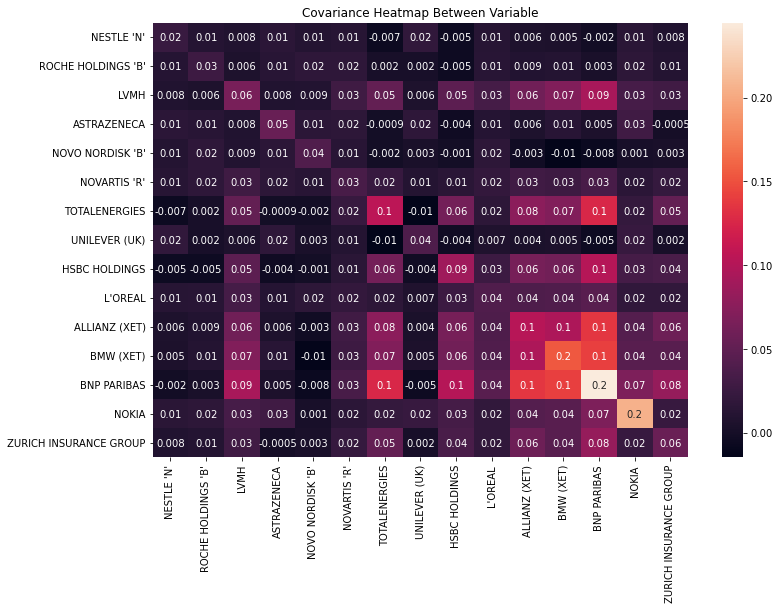

In [50]:
plt.figure(figsize=(12,8))
covariance = sigma
heatmap=sns.heatmap(covariance, annot=True, fmt='.1g')
heatmap.set_title('Covariance Heatmap Between Variable')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

In [51]:
max_div_vol = stats['Volatility']['Max div']
max_div_ret = maxDivIndexReturn1.mean()*12
erc_vol = stats['Volatility']['ERC']
erc_ret = ercIndexReturn.mean()*12

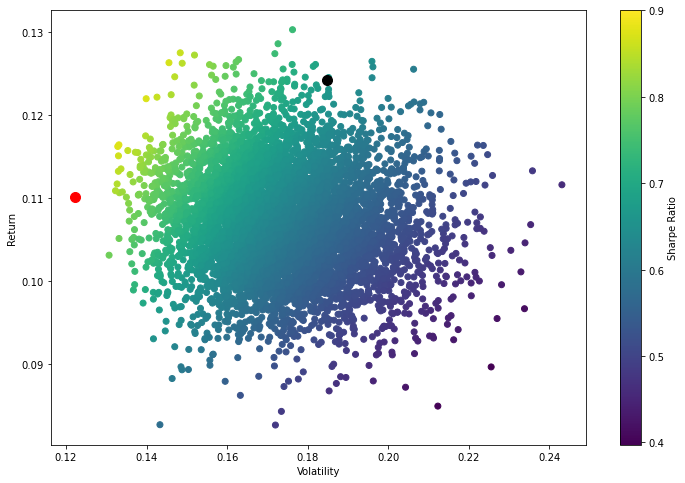

In [52]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100) # red dot
plt.scatter(max_div_vol, max_div_ret,c='black', s=100)# black dot
plt.show()

In [53]:

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 12
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*12, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [54]:
cons = ({'type':'eq','fun': check_sum})
bounds = [(0,1)]*15
init_guess = np.ones((1,15))/15


In [55]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds = bounds, constraints = cons, tol = 1e-8)
print(opt_results)

     fun: -1.0332078750541125
     jac: array([-4.88758087e-06, -1.33365393e-05, -3.94731760e-05, -2.19643116e-05,
        3.68505716e-05,  6.07901216e-02,  4.81787473e-02, -7.27176666e-06,
        3.04274946e-01, -6.79492950e-05,  4.78942111e-01,  1.89268589e-01,
        3.42898965e-01,  6.38182759e-02,  5.47723159e-01])
 message: 'Optimization terminated successfully'
    nfev: 144
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.14990561e-01, 3.89382100e-03, 1.35069647e-01, 6.32818199e-02,
       4.25466577e-01, 0.00000000e+00, 9.83683184e-17, 4.68192986e-02,
       0.00000000e+00, 1.10478275e-01, 2.80808363e-17, 9.70360944e-18,
       0.00000000e+00, 1.89057754e-17, 0.00000000e+00])


In [56]:
get_ret_vol_sr(opt_results.x)

array([0.16167055, 0.15647437, 1.03320788])

In [57]:
frontier_y = np.linspace(0,0.15,200)

In [58]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [59]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons, tol=1e-8)
    frontier_x.append(result['fun'])

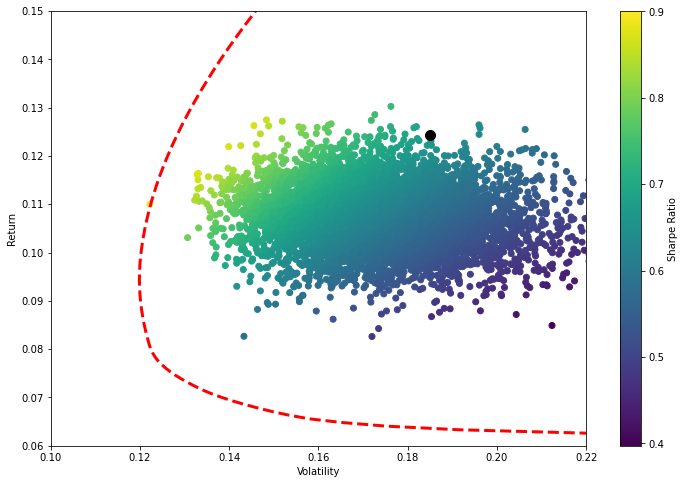

In [60]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.scatter(max_div_vol, max_div_ret,c='black', s=100)# black dot
plt.axis([0.1,0.22,0.06,0.15])
plt.show()

In [65]:
US_stocks_maxDD_series = index_df1/np.maximum.accumulate(index_df1)-1
US_stocks_maxDD = US_stocks_maxDD_series.min()

fig = px.line(US_stocks_maxDD_series, title="Underwater chart")
fig.layout.yaxis.tickformat = ',.0%'
fig.layout.yaxis.title = 'Max drawdown in %'
fig.show()

In [72]:
US_stocks_maxDD_series1 = index_df/np.maximum.accumulate(index_df)-1
US_stocks_maxDD1 = US_stocks_maxDD_series1.min()

fig = px.line(US_stocks_maxDD_series1, title="Underwater chart")
fig.layout.yaxis.tickformat = ',.0%'
fig.layout.yaxis.title = 'Max drawdown in %'
fig.show()